# FORECASTING MODEL

#### Importing python packages

In [7]:
import pandas as pd
from src.visualization.visualize import plot_time_series_graph
from src.models.forecasting.train_model import train_prophet_model
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from src.models.forecasting.predict_model import predict_prophet_model
from prophet.plot import plot_forecast_component
from src.models.forecasting.predict_model import predict_prophet_inference
from src.models.forecasting.predict_model import predict_naive_model_scores

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
train_data = pd.read_csv("../../data/interim/train_data_cleaned_encoded.csv")

In [58]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46985090 entries, 0 to 46985089
Data columns (total 8 columns):
 #   Column    Dtype  
---  ------    -----  
 0   item_id   int64  
 1   cat_id    int64  
 2   store_id  int64  
 3   state_id  int64  
 4   date      object 
 5   day       int64  
 6   month     int64  
 7   revenue   float64
dtypes: float64(1), int64(6), object(1)
memory usage: 2.8+ GB


In [59]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data = train_data[['date', 'revenue']]

In [60]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46985090 entries, 0 to 46985089
Data columns (total 2 columns):
 #   Column   Dtype         
---  ------   -----         
 0   date     datetime64[ns]
 1   revenue  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 716.9 MB


#### Plotting revenue across all years for observation

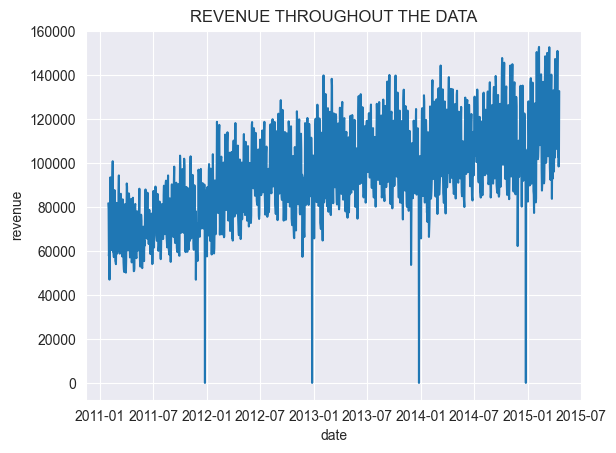

In [86]:
plot_time_series_graph(train_data,col_x='date', col_y='revenue')

In [87]:
train_data[train_data['revenue']<=5000]

,date,revenue
330,2011-12-25,23.68
696,2012-12-25,24.73
1061,2013-12-25,34.32
1426,2014-12-25,37.86


#### Observation:
- Sales is significantly low for 25th December. It might be because of Christmas holiday
- Adding information about holidays might improve the performance of the model.

#### Model Processing using Prophet model
- Prophet is a powerful timeseries prediction model.

In [62]:
train_data = train_data.groupby(['date'])['revenue'].sum().reset_index()

In [10]:
train_data.tail()

,date,revenue
1536,2015-04-14,102896.920137
1537,2015-04-15,106913.880156
1538,2015-04-16,98373.490092
1539,2015-04-17,103030.580119
1540,2015-04-18,132625.890126


#### SPLITTING TEST SET TO 7 DAYS
- We need prediction for the upcoming 7 days from the input date

In [13]:
df_train = train_data[train_data['date']<'2015-04-12']
df_test = train_data[train_data['date']>='2015-04-12']

#### USING PROPHET MODEL
- HOLIDAYS ACCORDING TO US EVENTS ARE ADDED TO THE MODEL AS WE OBSERVED IN THE DATASET THAT CHRISTMAS DAY THE SALES ARE SIGNIFICANTLY LOW.
- AS THE DATA IS BASED ON US, ADDING US HOLIDAYS TO FIND THE SIGNIFICANT TREND OF THE REVENUE

In [101]:
model = train_prophet_model(df_train, model_save=True, model_name='final_prophet_model.p')

15:36:55 - cmdstanpy - INFO - Chain [1] start processing
15:36:55 - cmdstanpy - INFO - Chain [1] done processing


In [102]:
model.train_holiday_names.to_list()

['Martin Luther King Jr. Day',
 "Washington's Birthday",
 'Columbus Day',
 "New Year's Day",
 'Memorial Day',
 'Independence Day',
 'Labor Day',
 'Veterans Day',
 'Thanksgiving',
 'Christmas Day',
 'Christmas Day (Observed)',
 "New Year's Day (Observed)",
 'Veterans Day (Observed)',
 'Independence Day (Observed)']

#### APPLYING CROSS VALIDATION ON TRAIN DATA
- To observe the robustness of the model

In [103]:
cv = cross_validation(model, initial='1460 days', period='7 days', horizon='7 days')

  0%|          | 0/10 [00:00<?, ?it/s]

15:37:33 - cmdstanpy - INFO - Chain [1] start processing
15:37:33 - cmdstanpy - INFO - Chain [1] done processing
15:37:34 - cmdstanpy - INFO - Chain [1] start processing
15:37:34 - cmdstanpy - INFO - Chain [1] done processing
15:37:35 - cmdstanpy - INFO - Chain [1] start processing
15:37:35 - cmdstanpy - INFO - Chain [1] done processing
15:37:35 - cmdstanpy - INFO - Chain [1] start processing
15:37:35 - cmdstanpy - INFO - Chain [1] done processing
15:37:36 - cmdstanpy - INFO - Chain [1] start processing
15:37:36 - cmdstanpy - INFO - Chain [1] done processing
15:37:36 - cmdstanpy - INFO - Chain [1] start processing
15:37:37 - cmdstanpy - INFO - Chain [1] done processing
15:37:37 - cmdstanpy - INFO - Chain [1] start processing
15:37:37 - cmdstanpy - INFO - Chain [1] done processing
15:37:38 - cmdstanpy - INFO - Chain [1] start processing
15:37:38 - cmdstanpy - INFO - Chain [1] done processing
15:37:38 - cmdstanpy - INFO - Chain [1] start processing
15:37:39 - cmdstanpy - INFO - Chain [1]

In [104]:
scores = performance_metrics(cv)
scores

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,1.659194e+08,12880.972103,10410.758810,0.071192,0.052945,0.074897,0.6
1,2 days,5.043421e+07,7101.704590,6569.514600,0.060141,0.059653,0.060538,0.8
2,3 days,8.659557e+07,9305.674033,8244.825064,0.084511,0.062696,0.082648,0.7
3,4 days,6.636171e+07,8146.269856,6782.718133,0.069815,0.065412,0.068252,0.8
4,5 days,7.466325e+07,8640.789939,7707.785482,0.077975,0.077290,0.076666,0.7
5,6 days,9.120189e+07,9549.968207,7037.876172,0.062850,0.048940,0.062676,0.7
6,7 days,1.066112e+08,10325.271067,8120.651987,0.056876,0.045859,0.059293,0.6


#### Visualizing RMSE across 7 days

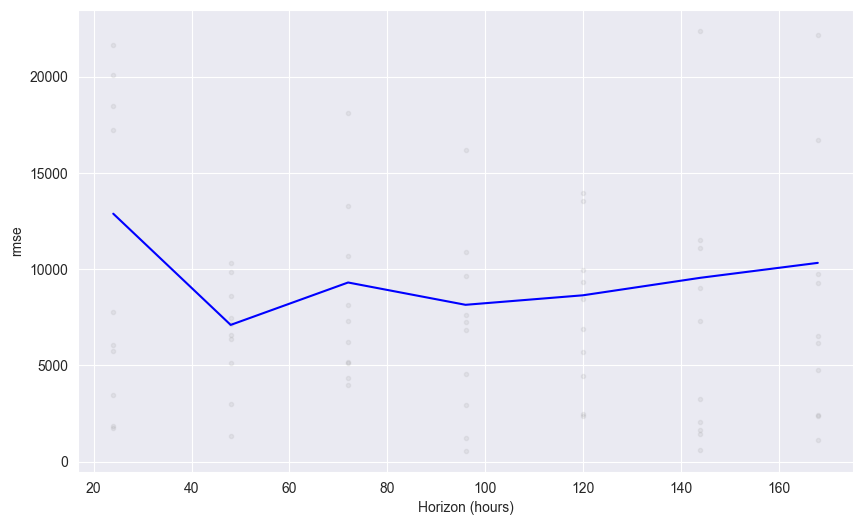

In [105]:
fig = plot_cross_validation_metric(cv, metric='rmse')

#### Model comparison with naive model and analysing prophet model performance on test data

In [146]:
predict_naive_model_scores(df_test)

MAE SCORE for Naive Model:15444.832247840823
RMSE SCORE for Naive Model:18020.673501782094
R2 SCORE for Naive Model:0.0


E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\src\models\forecasting\predict_model.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_prediction = np.mean(y_test['revenue'])


MAE SCORE for TEST:5451.242772737736
RMSE SCORE for TEST:8111.224730626425
R2 SCORE for TEST:0.7974040161146202


E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\venv\lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\venv\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\venv\lib\site-packages\prophet\plot.py:226: FutureWarning: The behavior of DatetimeProperties.t

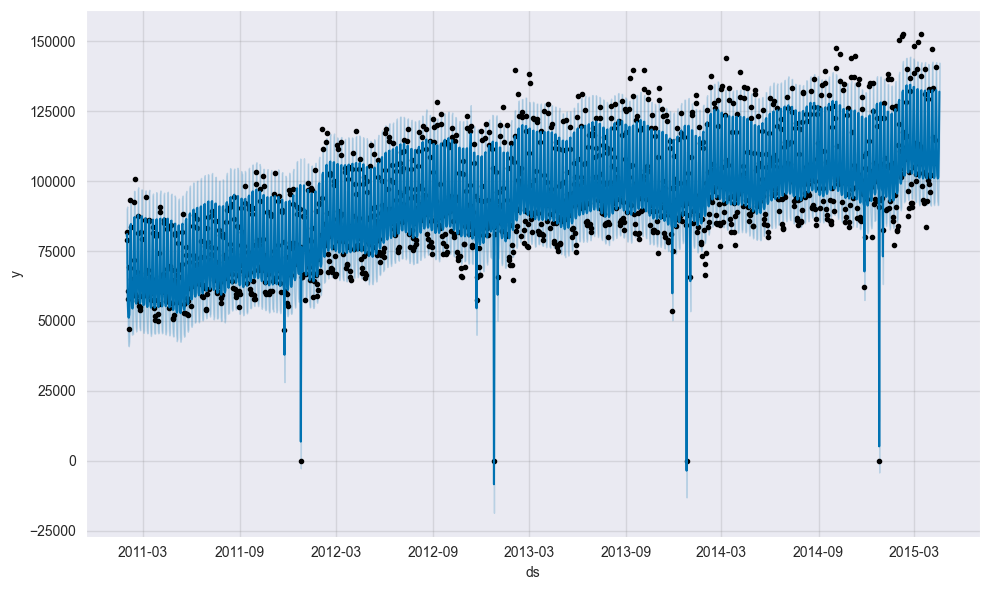

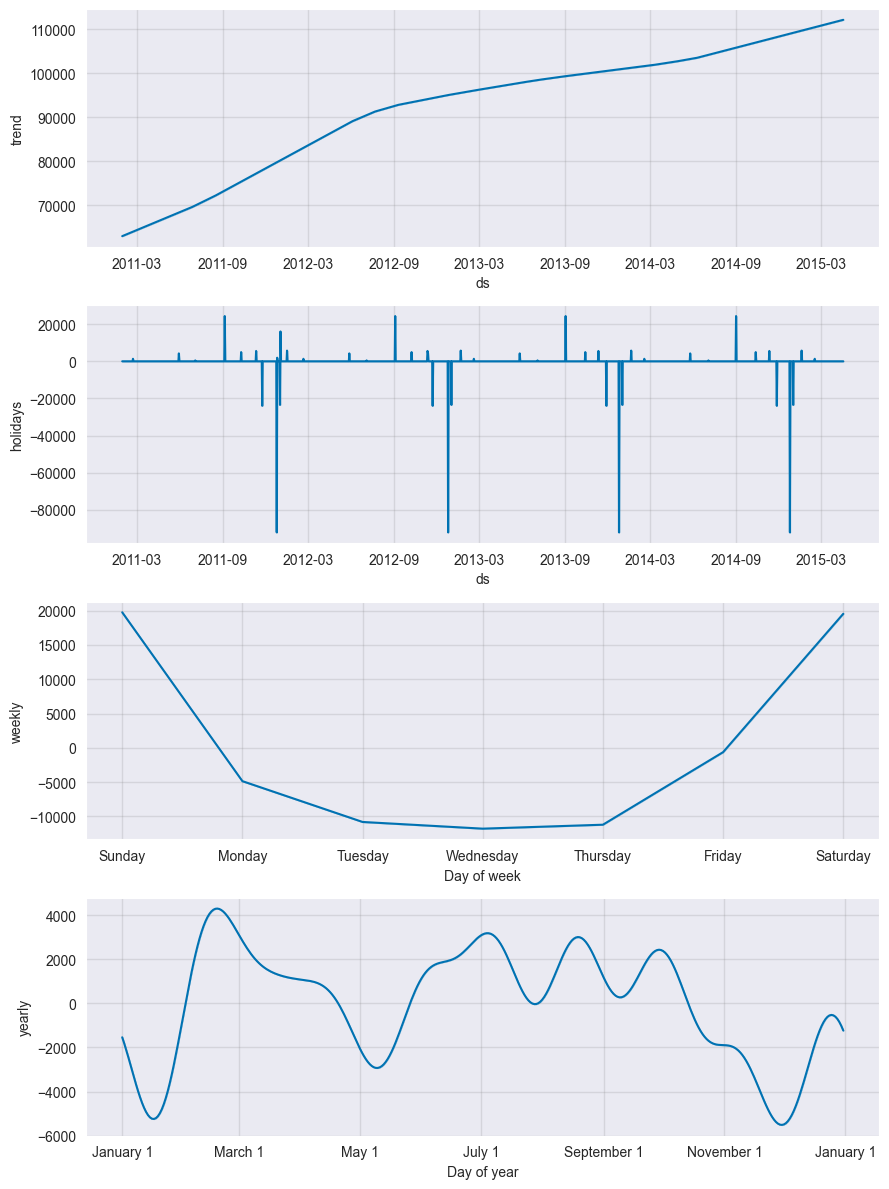

In [106]:
p_forecast = predict_prophet_model(model,df_test)

E:\UTS_2nd_Semester\Advanced_MLA\machine_learning_as_a_service_assignment_2\venv\lib\site-packages\prophet\plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


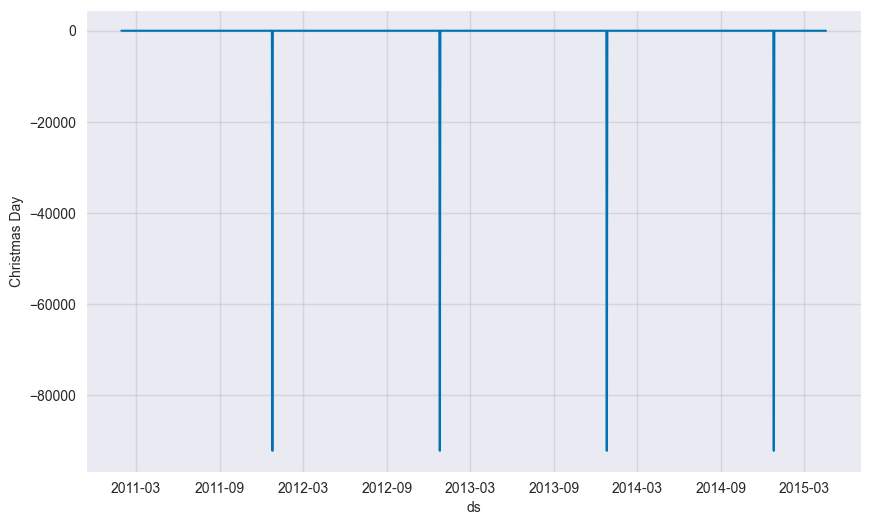

In [107]:
plot_forecast_component(model, p_forecast, 'Christmas Day')

#### Observation of model performance:
- The model was able to extract information from US holidays as well.
- It stored information of significant drop created by christmas date and will be useful for future prediction

#### Inference prediction and model deployment

In [26]:
pred_date = '2014-12-23'
output = predict_prophet_inference(model_name_file='final_prophet_model.p', date=pred_date)

In [27]:
output

[['2014-12-23', 97521.8659822305],
 ['2014-12-24', 96648.51473780908],
 ['2014-12-25', 5117.519373868257],
 ['2014-12-26', 107882.96156770458],
 ['2014-12-27', 128031.95546911302],
 ['2014-12-28', 128179.08096818894],
 ['2014-12-29', 103465.31822203439]]